In [1]:
#Dependencies
# xarray, cfgrib
#For plotting
# matplotlib, scipy, cartopy

In [2]:
#Define the folders where data is labelled
satellite_folder = '/perm/rd/pamc/Land/MODIS/AquaDay/' #Recommend saving all satellite files to the same folder
era_folder = '/perm/rd/pamc/Land/ERA/'

In [3]:
#These dictionaries describe the local hour of the satellite
local_times = {"aquaDay":"13:30",
               "terraDay":"10:30",
               "terraNight":"22:30",
               "aquaNight":"01:30"
              }
# and are used to load the correct file for dealing with the date-line.
min_hours = {"aquaDay":2,
            "terraDay":-1,
            "aquaNight":-1,
            "terraNight":11}
max_hours = {"aquaDay":24,
            "terraDay":22,
            "aquaNight":13,
            "terraNight":24}


In [55]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [60]:
#Data loader for the satellite data,
#returns a complete global map (regular lat-lon)
#but sparsely filled, with only one stripe of data
#showing where the satellite passed that hour
def get_satellite_slice(date : str,
                        utc_hour : int,
                        satellite='aquaDay',
                        latitude_bound = None #Recommend only using |lat| < 70 degrees
                       ):
    #Due to crossing of the datetime, some times will be saved different date
    if utc_hour < min_hours[satellite]:
        file_date = str((np.datetime64(date) - np.timedelta64(1,'D')))
    elif utc_hour > max_hours[satellite]:
        file_date = str((np.datetime64(date) + np.timedelta64(1,'D')))
    else:
        file_date = date
    #Open .tif file
    sat_xr = xr.open_rasterio(f'{satellite_folder}/{satellite}_errorGTE03K_04km_{file_date}.tif')
    #Rename spatial dimensions
    sat_xr = sat_xr.rename({'x':'longitude','y':'latitude'})
    #Create time delta to change local to UTC
    time_delta = pd.to_timedelta(sat_xr.longitude.data/15,unit='H') 
    #Convert local satellite time to UTC and round to nearest hour
    time = (pd.to_datetime([file_date + " " + local_times[satellite]]*time_delta.shape[0]) - time_delta).round('H')
    #print(time)
    #Select desired hour
    dt = np.datetime64(f'{date} {utc_hour:02}:00:00')
    right_time = np.expand_dims(time == dt,axis=(0,1))
    if right_time.sum() == 0:
        print("Warning: Correct time not found in dataset, likely problem in file selection")
    #Make subset
    subset = np.logical_and(np.isfinite(sat_xr),right_time)
    if subset.sum() == 0:
        print(f"Warning: No valid data found for {date} {utc_hour:02}h")
    if latitude_bound is not None:
        #print(f"Subsetting < {latitude_bound}")
        subset = np.logical_and(subset,np.expand_dims(np.abs(sat_xr.latitude) < latitude_bound,axis=(0,-1)))
    #Select valid data
    test_subset = sat_xr.where(subset).load()
    sat_xr.close()
    sat_xr = None
    return test_subset[0,::-1,:]

#Data loader for ERA. Much simpler, just select the correct file
def get_era_data(date : str,
                 utc_hour : int,
                 field = 't2m'):

    month = '_'.join(date.split('-')[:-1])
    ds_era = xr.open_dataset(f'{era_folder}/sfc_unstructured_{month}.grib',engine='cfgrib')
    #Grab correct field
    da = ds_era[field]
    #
    time_str = f"{date} {utc_hour:02}:00:00" 
    da = da.sel(time=time_str)
    #Relabel longitude coordinate to be consistent with MODIS
    da = da.assign_coords({"longitude": (((da.longitude + 180) % 360) - 180)})
    
    #Load data, perhaps this is too early?
    da = da.load()
    
    #Close file, attempt to not have memory leaks
    ds_era.close()
    ds_era = None
    return da

#This is the main data loader, getting the era data, the satellite data and the mask for where data exists
def get_inputs_outputs(date : str,
                       utc_hour : int,
                       satellite='aquaDay',
                       latitude_bound = None #Recommend only using |lat| < 70 degrees
                      ):
    
    modis = get_satellite_slice(date,utc_hour = utc_hour,
                                satellite=satellite,
                                latitude_bound = latitude_bound
                               )
    
    mask = np.isnan(modis).astype(int)
    
    era = get_era_data(date = date,
                       utc_hour = utc_hour,
                      )
    return era, modis, mask

#For plotting only
def grid_era(da):
    from scipy.interpolate import griddata
    xi = np.linspace(-180, 180, 1024)
    yi = np.linspace(-89.95,89.95,512)
    xi, yi = np.meshgrid(xi, yi)

    x, y, z = da.longitude.data, da.latitude.data, da.data
    zi = griddata((x,y), z, (xi, yi))
    
    return xi, yi, zi

In [29]:
#Get satellite data for a given day and time
era, modis, mask = get_inputs_outputs('2018-01-03', #Valid values, dates in 2018, 2019,2020
                                      utc_hour = 10, #Valid values range(24)
                                      latitude_bound=65,
                                      satellite = 'aquaDay', #Valid values, 'aquaDay','aquaNight','terraDay','terraNight'
                                     )


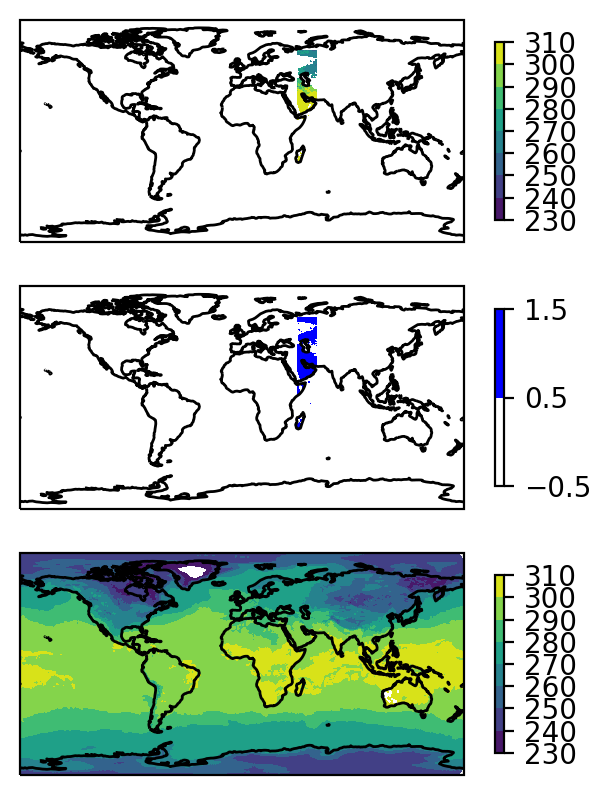

In [59]:
fig,ax = plt.subplots(3,1,dpi=200,figsize=(4,5),
                      subplot_kw={'projection': ccrs.PlateCarree()}
                     )

### Plot MODIS
coast = ax[0].coastlines()
#Make grid for plotting purposes
xv, yv = np.meshgrid(modis.longitude, modis.latitude, indexing='xy')
#Contour plot
contourf_=ax[0].contourf(xv,yv,modis,levels=np.arange(230,320,10))
cbar = fig.colorbar(contourf_,ax=ax[0],location='right',shrink=0.8)

### Plot Mask
coast = ax[1].coastlines()
#Make grid for plotting purposes
#Contour plot
cmap = mpl.colors.ListedColormap(['w', 'b'])
contourf_=ax[1].contourf(xv,yv,
                         #Note we plot 1 - mask
                         1 - mask, levels = [-0.5,0.5,1.5],
                         cmap=cmap)
cbar = fig.colorbar(contourf_,ax=ax[1],location='right',shrink=0.8)

### Plot ERA
x,y,z = grid_era(era)
coast = ax[2].coastlines()
#Make grid for plotting purposes
#Contour plot
contourf_=ax[2].contourf(x,y,z,levels=np.arange(230,320,10))
cbar = fig.colorbar(contourf_,ax=ax[2],location='right',shrink=0.8)


In [46]:
#DataArray for ERA at a specific time/day

#Note the single horizontal axis which captures both lat and lon variability.
era

<xarray.DataArray 't2m' (values: 542080)>
array([248.22469, 248.50398, 248.77547, ..., 248.84773, 248.92781,
       248.99617], dtype=float32)
Coordinates:
    number      int64 0
    time        datetime64[ns] 2018-01-03T10:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... -80.0 -60.0 -40.0 -20.0
    valid_time  datetime64[ns] 2018-01-03T10:00:00
Dimensions without coordinates: values
Attributes: (12/21)
    GRIB_paramId:                    167
    GRIB_dataType:                   an
    GRIB_numberOfPoints:             542080
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    ...                              ...
    GRIB_shortName:                  2t
    GRIB_totalNumber:                0
    GRIB_units:                      K
    long_name:                       2 metre temperature
    units:                           K
    standard_name:                   unknown

In [49]:
#Data is laid out on disk as bands sweeping from north to south pole.
print(era.latitude.data)

[ 89.78487691  89.78487691  89.78487691 ... -89.78487691 -89.78487691
 -89.78487691]


In [50]:
#To be ~equispace in km the deltas in longitude near the poles are large (20degrees)
print(era.longitude.data)

[  0.  20.  40. ... -60. -40. -20.]
